<a href="https://colab.research.google.com/github/fedIce/CriminalDilemmaChallenge/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#download data
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163 (from 1)
Receiving objects: 100% (12163/12163), 156.98 MiB | 21.41 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [131]:
!pip install imgaug
# !pip uninstall "numpy"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 86.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import ntpath
import random
import os
import pandas as pd
# 1.26.4

In [133]:
import imgaug.augmenters as iaa

In [100]:
datadir = 'track'
columns = ['center', 'left', 'right','sterring','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', 1)
data.head()

center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [101]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail


data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [102]:
data['sterring'].min()

-1.0

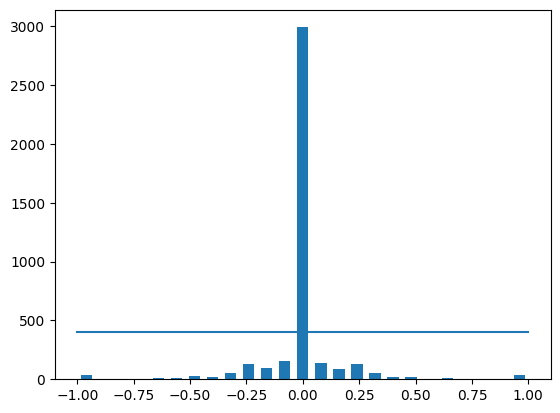

In [103]:
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['sterring'], num_of_bins)
center = (bins[:-1] + bins[1:]) * 0.5
# print((bins[:-1] + bins[1:])*0.1)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['sterring']), np.max(data['sterring'])), (samples_per_bin, samples_per_bin))

In [104]:
print("total data", len(data))
print(data.shape)

total data 4053
(4053, 7)


In [105]:
remove_list = []
for j in range(num_of_bins):
  list_ = []
  for i in range(len(data['sterring'])):
    if data['sterring'][i] >= bins[j] and data['sterring'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print(bins)
print('removed:', len(remove_list))
print(len(data['sterring']), num_of_bins)
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
removed: 2590
4053 25
remaining: 1463


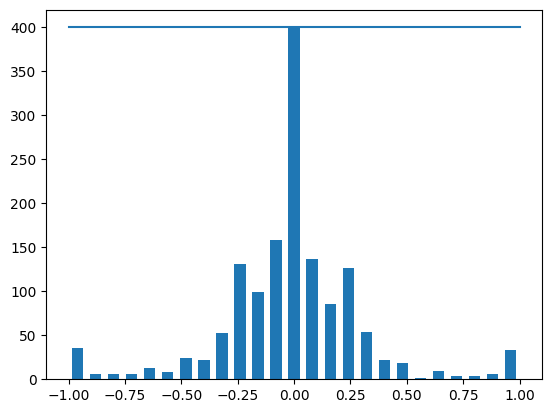

In [106]:
hist, _ = np.histogram(data['sterring'], num_of_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['sterring']), np.max(data['sterring'])), (samples_per_bin, samples_per_bin))

In [126]:
def load_image_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

    # left image append
    image_path.append(os.path.join(datadir, left.strip()))
    steering.append(float(indexed_data[3]) + 0.15)

    # right image append
    image_path.append(os.path.join(datadir, right.strip()))
    steering.append(float(indexed_data[3]) - 0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [116]:
data.head()

center  ...     speed
0   center_2018_07_16_17_11_43_382.jpg  ...  0.649786
4   center_2018_07_16_17_11_43_860.jpg  ...  0.615438
11  center_2018_07_16_17_11_44_342.jpg  ...  0.946799
12  center_2018_07_16_17_11_44_413.jpg  ...  1.434013
13  center_2018_07_16_17_11_44_485.jpg  ...  2.173052

[5 rows x 7 columns]

In [127]:
image_paths, steerings = load_image_steering(datadir + '/IMG', data)

<ipython-input-126-a3cef8b4cf10>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-126-a3cef8b4cf10>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
<ipython-input-126-a3cef8b4cf10>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]) + 0.15)
<ipython-input-126-a3cef8b4cf1

In [129]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print(f'Training Samples: {len(X_train)} \n Valid Samples: {len(X_valid)}')

Training Samples: 3511 
 Valid Samples: 878


Text(0.5, 1.0, 'Validation Set')

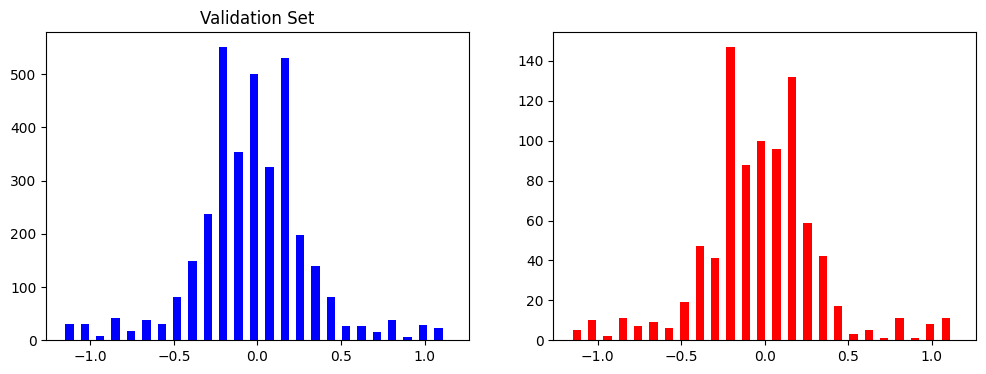

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_of_bins, width=0.05, color='blue')
axes[0].set_title("Training Set")
axes[1].hist(Y_valid, bins=num_of_bins, width=0.05, color='red')
axes[0].set_title("Validation Set")

In [172]:
def visualize_image(func, op = "change", with_steering=False):
  random_index = random.randint(1, 1000)
  image = image_paths[random_index]
  original_image = mpimg.imread(image)
  steering_angle = steerings[random_index]
  flipped_steering_angle = None
  if with_steering:
    changed_image, flipped_steering_angle = func(original_image, steering_angle)
  else:
    changed_image = func(original_image)

  fig, axs = plt.subplots(1, 2, figsize=(15, 10))
  fig.tight_layout()

  axs[0].imshow(original_image)
  axs[0].set_title(f'Original Image {f" - Steering Angle {steering_angle}"if flipped_steering_angle else ""}')

  axs[1].imshow(changed_image)
  axs[1].set_title(f'{op}ed Image {f" - Steering Angle {flipped_steering_angle}"if flipped_steering_angle else ""}')

In [165]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image


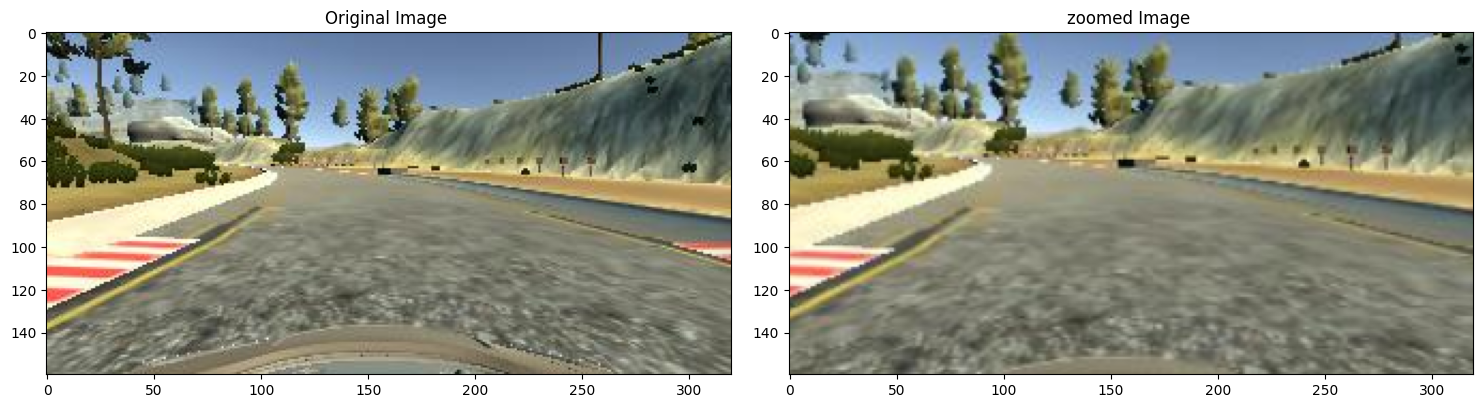

In [166]:
visualize_image(zoom, 'zoom')

In [149]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x": (-0.1, 0.1), "y": (-0.1, 0.1) })
  image = pan.augment_image(image)
  return image

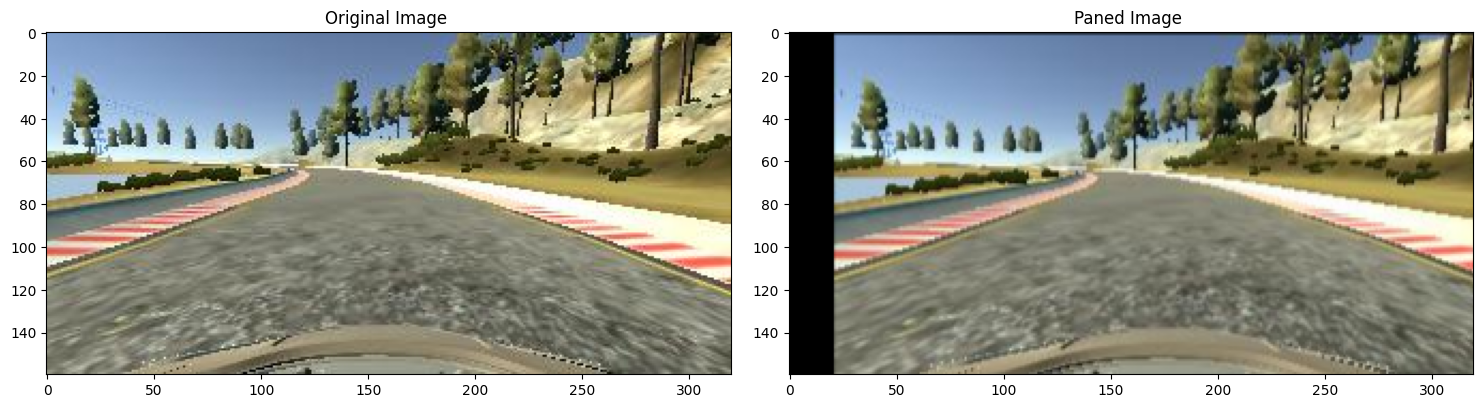

In [167]:
visualize_image(pan, "Pan")

In [168]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

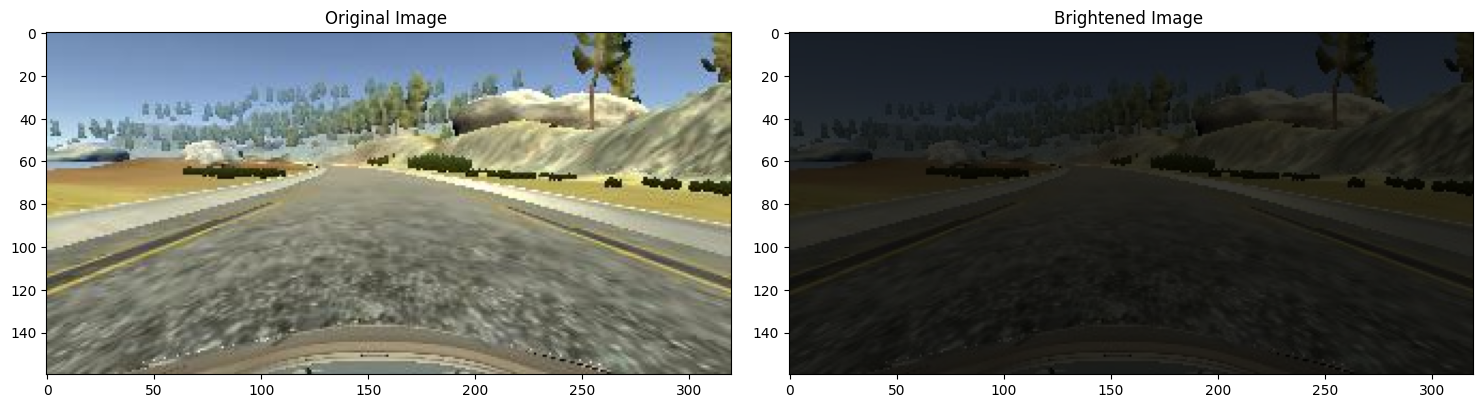

In [169]:
visualize_image(img_random_brightness, "Brighten")

In [170]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle


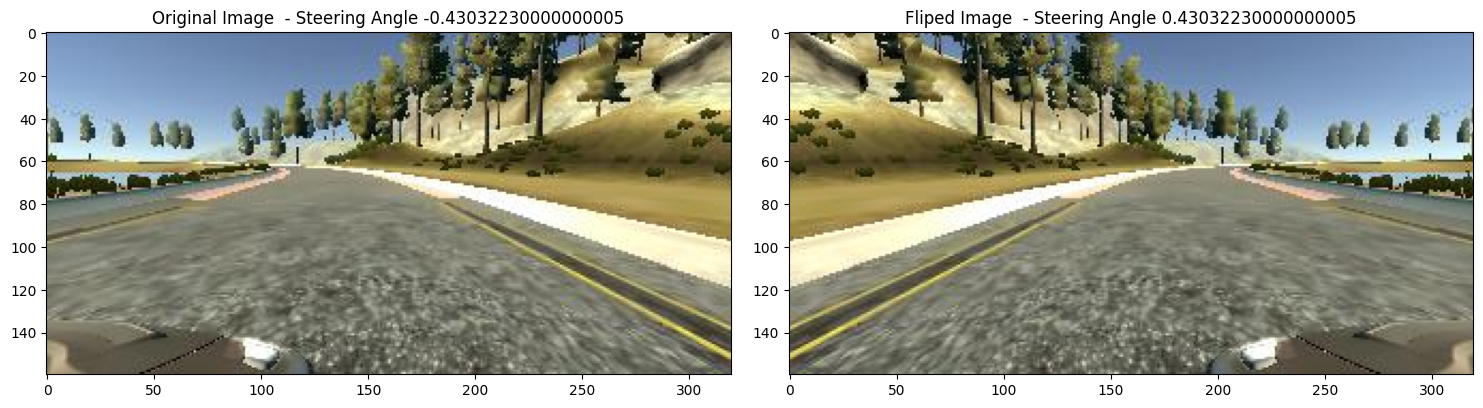

In [173]:
visualize_image(img_random_flip, 'Flip', True )

In [189]:
def random_argument():
  for f in [pan, zoom, img_random_brightness, img_random_flip]:
    if np.random.rand() < 0.5:
      if f.__name__ in ["pan", "zoom","img_random_brightness"]:
        visualize_image(f, f.__name__)
      else:
        visualize_image(f, f.__name__, True)

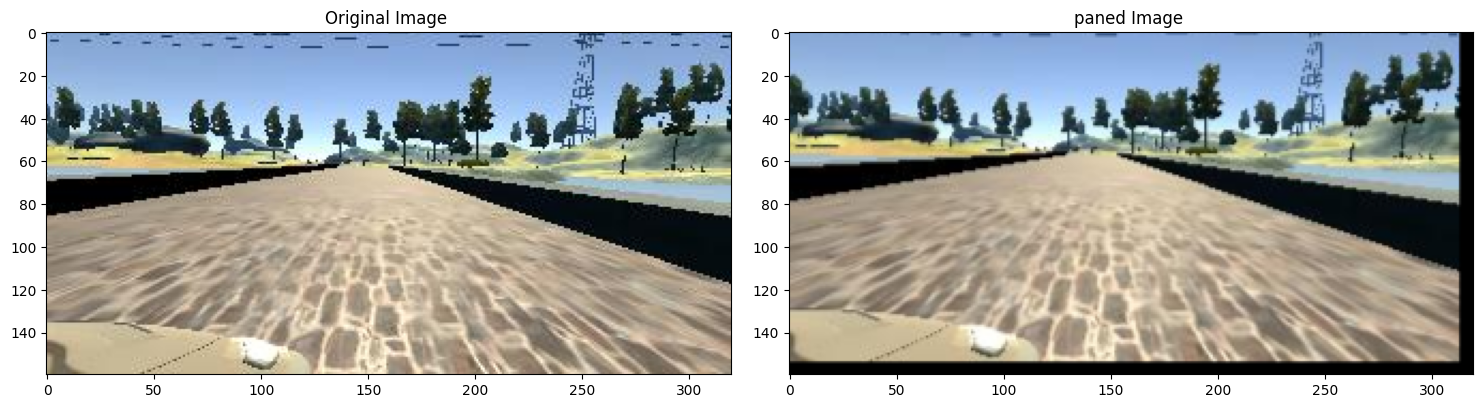

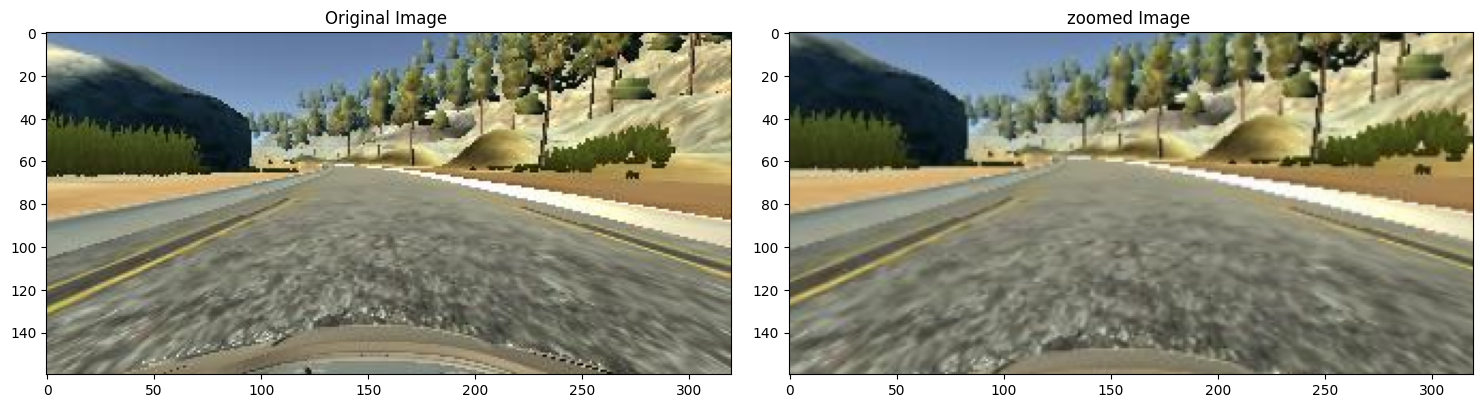

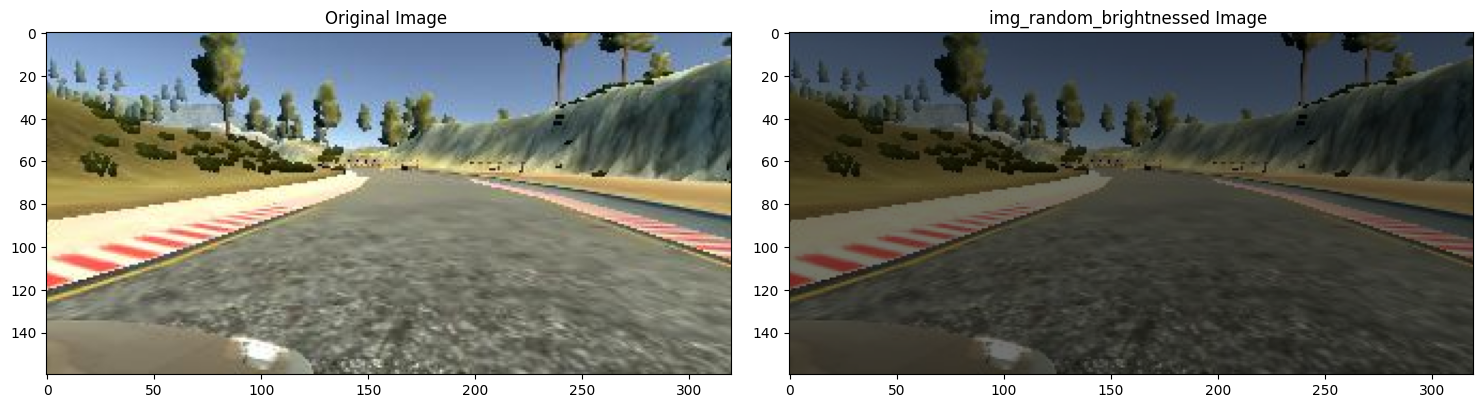

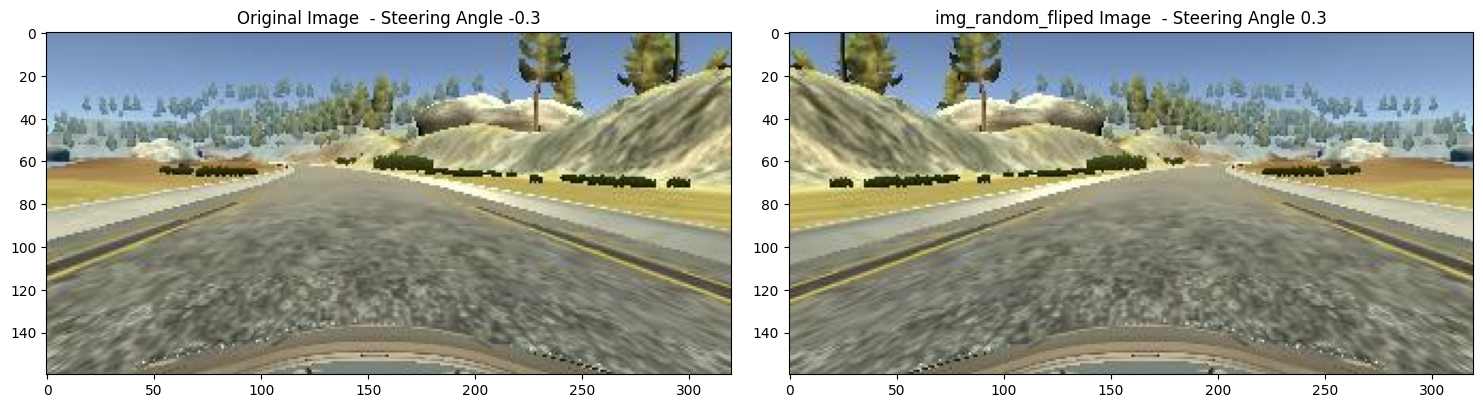

In [191]:
random_argument()